# NLP with cleaned data and CNN

In [83]:
from NLPmoviereviews.data import load_data_sent
from NLPmoviereviews.utilities import preprocessing

X_train, y_train, X_test, y_test = load_data_sent(percentage_of_sentences=10)

In [84]:
X_train = [preprocessing(_) for _ in X_train]
X_train = [_.split() for _ in X_train]

In [85]:
X_test = [preprocessing(_) for _ in X_test]
X_test = [_.split() for _ in X_test]

## Tokenize the text

In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
vocab_size=len(tokenizer.word_index)

In [87]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad=pad_sequences(X_train_token, dtype=float, padding='post', maxlen=200)
X_test_pad=pad_sequences(X_test_token, dtype=float, padding='post', maxlen=200)

X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape

((2500, 200), (2500,), (2500, 200), (2500,))

In [88]:
from tensorflow.keras import models,layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
reg_l1 = regularizers.L1(0.001)
reg_l1l2= regularizers.L1L2(l1=0.0005, l2=0.0005)
embedding_size=100

model=models.Sequential()
#model.add(layers.Masking(mask_value=0, input_shape=(pad_length,100)))
model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_size, mask_zero=True, input_length=200))
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(32, kernel_size=2, activation='relu', kernel_regularizer=reg_l1))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu", activity_regularizer=reg_l1l2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
optim=Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

In [89]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

history=model.fit(X_train_pad, y_train, 
          epochs=200, 
          batch_size=32,
          validation_split=0.3,
          verbose=0,
          callbacks=[es]
         )


res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
The accuracy evaluated on the test set is of 51.320%


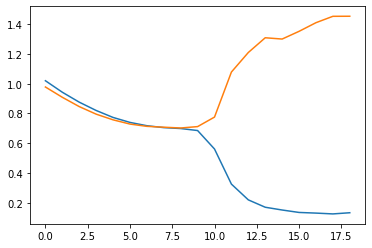

In [90]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [91]:
model.predict(X_test_pad)

array([[0.49620798],
       [0.50226873],
       [0.5015236 ],
       ...,
       [0.49562013],
       [0.4980402 ],
       [0.4932245 ]], dtype=float32)

In [92]:
y_test

array([1, 1, 0, ..., 0, 0, 0])